/home/tillstehling/miniconda3/lib/python3.11/site-packages/refractiveindex/refractiveindex.py:300: RuntimeWarning: invalid value encountered in sqrt
  n = np.sqrt(nsq)


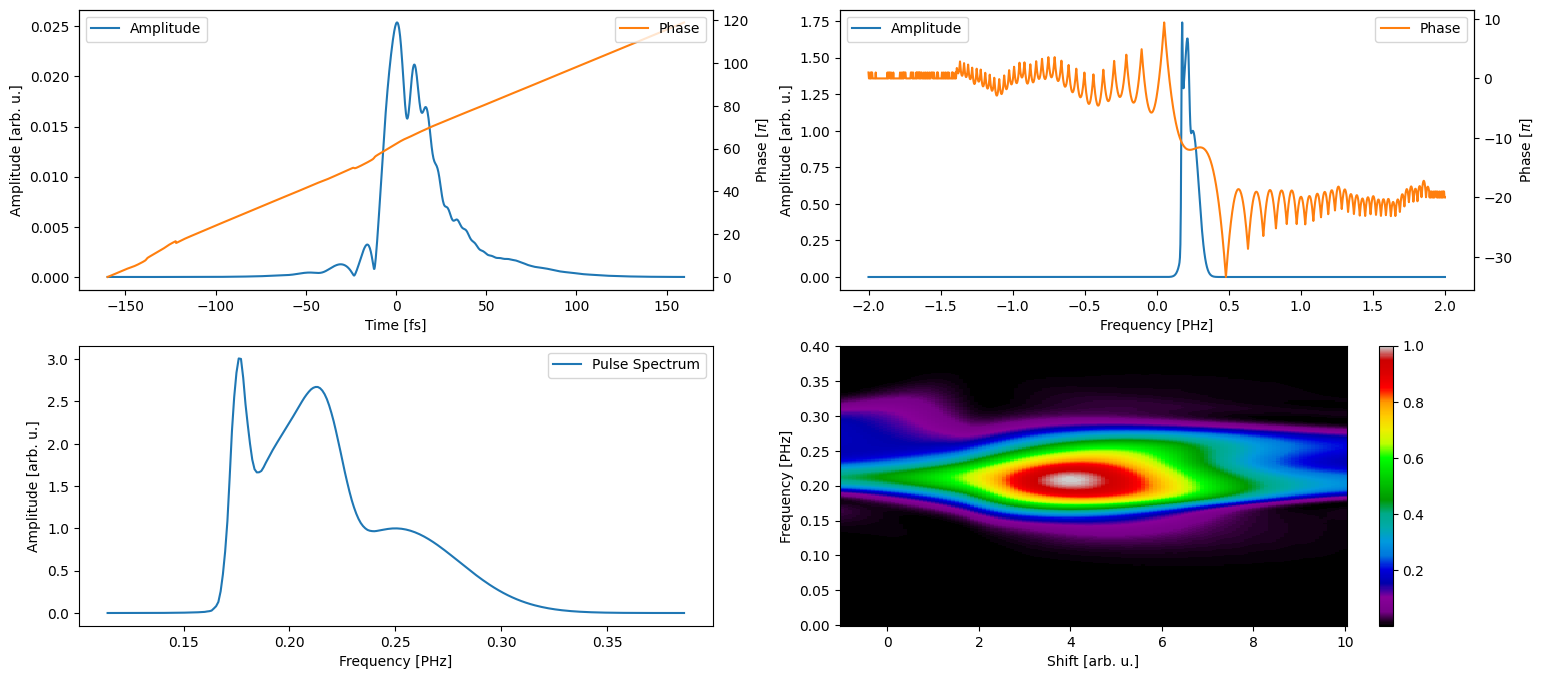

In [1]:
from pulsedjax.simulate_trace import MakeTrace
from pulsedjax.simulate_trace import GaussianAmplitude, PolynomialPhase
import jax.numpy as jnp
import matplotlib.pyplot as plt
import refractiveindex

amp0 = GaussianAmplitude((1,1,1), (0.175,0.2,0.25), (0.01,0.05,0.1), (1,2,1))
phase0 = PolynomialPhase(None, (0,0,20,-30))

amp1 = GaussianAmplitude((1), (0.25), (0.05), (3))
phase1 = PolynomialPhase(None, (0,0,-20,30))

mp = MakeTrace(N=128*10, f_max=2)
time, frequency, pulse_t, pulse_f = mp.generate_pulse((amp0,phase0))

_, frequency_gate, _, pulse_f_gate = mp.generate_pulse((amp1,phase1))


# import refractiveindex
# parameters = refractiveindex.RefractiveIndexMaterial(shelf="main", book="SiO2", page="Malitson")
# z_arr = jnp.linspace(-5,5,128) 
# z_arr, frequency_trace, trace, spectra = mp.generate_chirpscan(time, frequency, pulse_t, pulse_f, "shg", 
#                                                                z_arr, phase_type="material", parameters=parameters,
#                                                                frequency_range=(0.1,0.65), N=128)



theta = jnp.linspace(-1,10,128) 
theta, frequency_trace, trace, spectra = mp.generate_chirpscan(time, frequency, pulse_t, pulse_f, "pg", theta, phase_type="material",
                                                               chirp_parameters=refractiveindex.RefractiveIndexMaterial(shelf="main", book="SiO2", page="Malitson"),
                                                               N=128*2, frequency_range=(0,0.4))


/home/tillstehling/miniconda3/lib/python3.11/site-packages/refractiveindex/refractiveindex.py:297: RuntimeWarning: invalid value encountered in divide
  g = lambda c1, c2, w: c1 * (w ** 2) / (w ** 2 - c2 ** 2)
/home/tillstehling/miniconda3/lib/python3.11/site-packages/refractiveindex/refractiveindex.py:300: RuntimeWarning: invalid value encountered in sqrt
  n = np.sqrt(nsq)


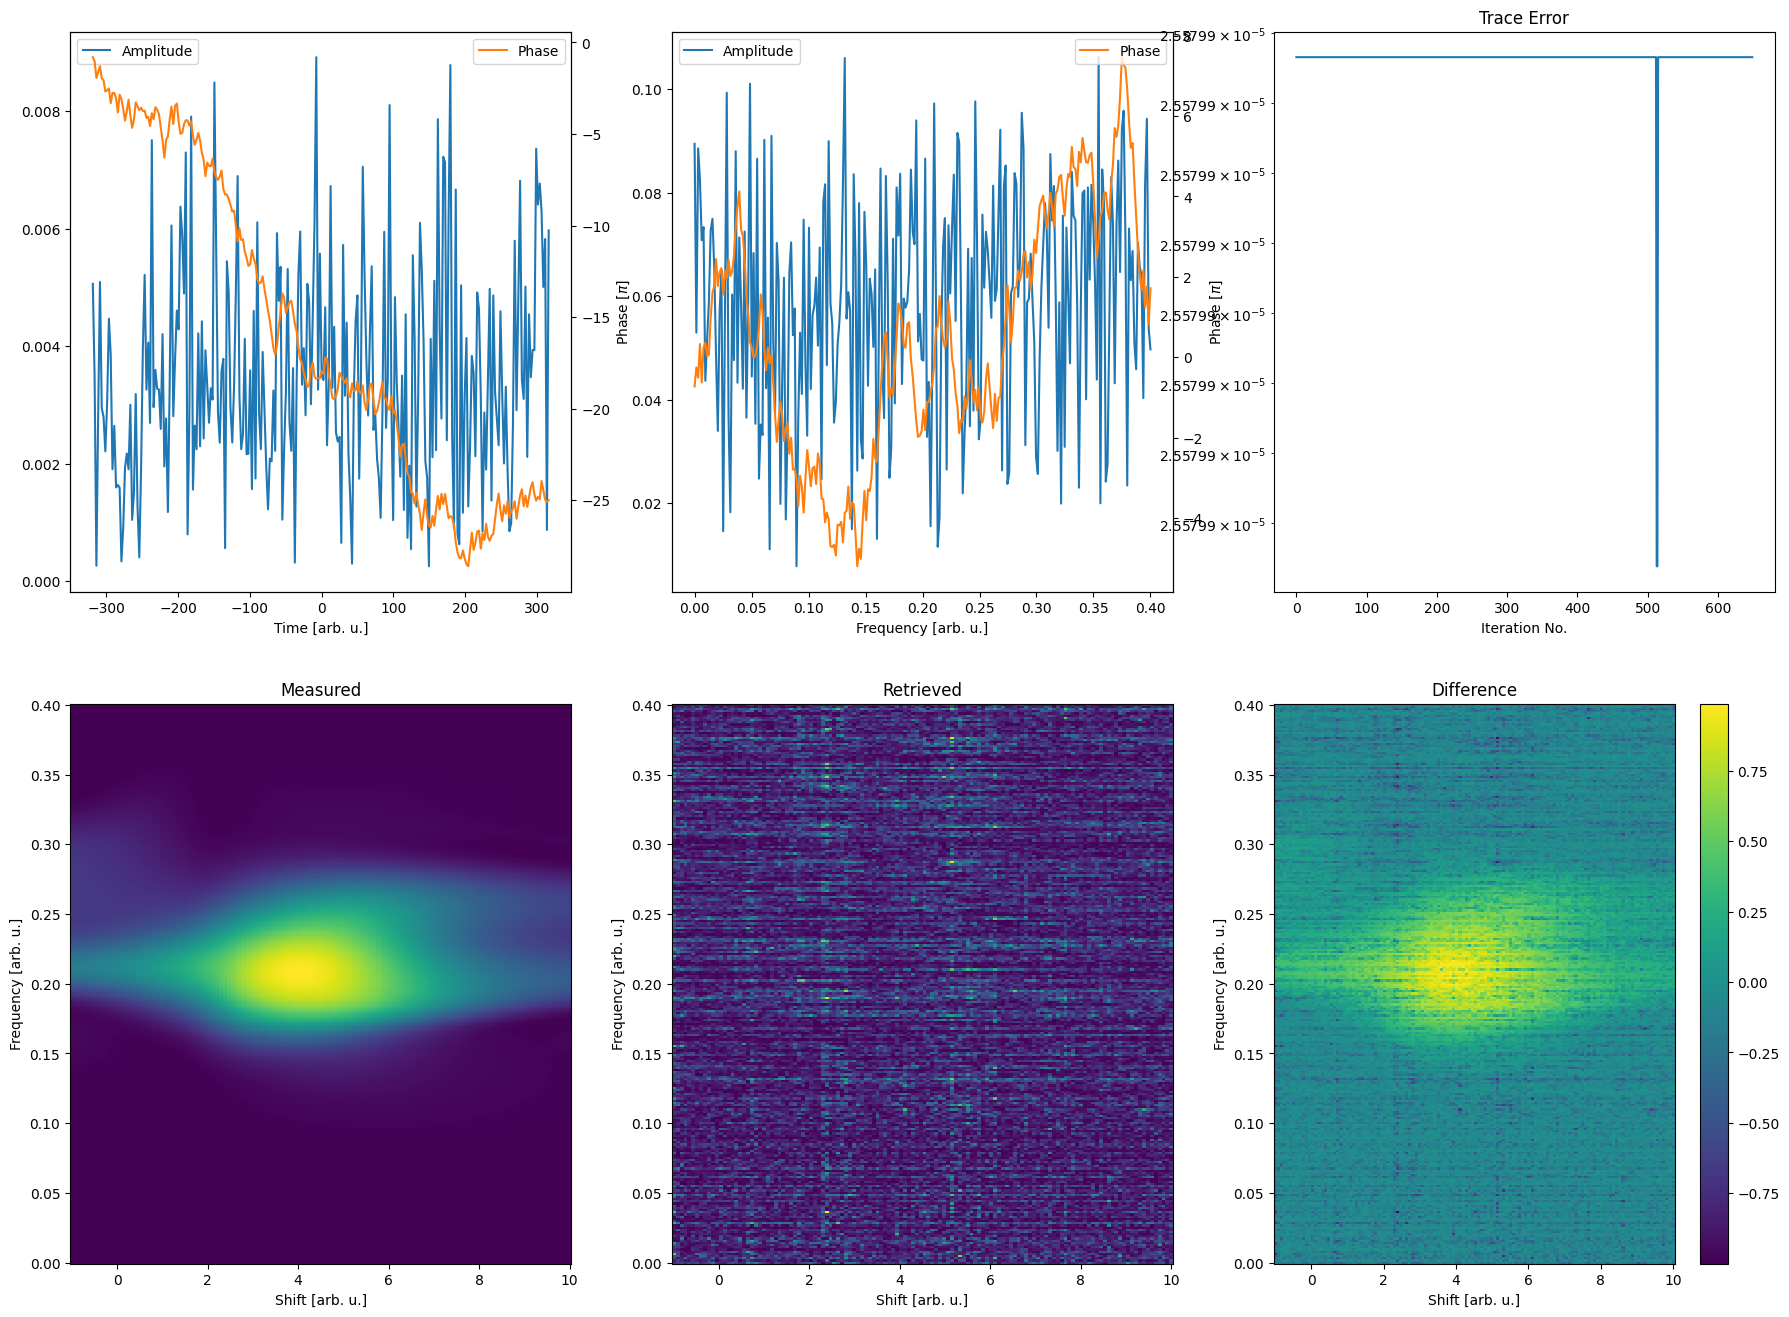

In [2]:
from pulsedjax.chirp_scan import COPRA

pie = COPRA(theta, frequency_trace, trace, "pg", phase_type="material", 
                                   chirp_parameters=refractiveindex.RefractiveIndexMaterial(shelf="main", book="SiO2", page="Malitson"))#, cross_correlation="doubleblind")

# pie.use_measured_spectrum(spectra.pulse[0], spectra.pulse[1], "pulse")
# pie.use_measured_spectrum(spectra.gate[0], spectra.gate[1], "gate")

population = pie.create_initial_population(1, "random")

#pie.alpha = 0.15
pie.local_gamma = 1
pie.global_gamma = 1e-3


# pie.set_nonlinear_optimization(local_method=False, global_method="lbfgs", memory=10)
# pie.set_linesearch(method="zoom", delta_gamma=1.25, max_steps=5)
#pie.set_S_prime_params(global_method="projection")


final_result = pie.run(population, 150, 500)
pie.plot_results(final_result)

In [3]:
#Hkk' Dkn x Pmk^* x Dnj Pmj Hjj'

In [4]:
signal_t = pie.generate_signal_t(pie.descent_state, pie.measurement_info, pie.descent_info)

In [5]:
time, omega = pie.measurement_info.time, 2*jnp.pi*pie.measurement_info.frequency

In [ ]:
time, omega = pie.measurement_info.time, 2*jnp.pi*pie.measurement_info.frequency
Dkn = jnp.exp(1j*(time[:,jnp.newaxis]*omega[jnp.newaxis,:]))*1/jnp.sqrt(256)
Pmk = signal_t.gate_disp
phase_matrix = pie.measurement_info.phase_matrix

In [7]:
H = jnp.einsum("kn,mn,jn->mkj", Dkn, phase_matrix, Dkn)

In [8]:
GN = jnp.einsum("mik,kn,Nmk,Nmj,jn,mju -> Niu", H.conj(), Dkn, Pmk.conj(), Pmk, Dkn.conj(), H)

In [11]:
trace = jnp.sqrt(jnp.abs(pie.measurement_info.measured_trace))

subel = (2 - jnp.sqrt(jnp.abs(trace))/(jnp.abs(signal_t.signal_f) + 1e-15))

In [20]:
subel.shape

(1, 128, 256)

In [19]:
Hzz = jnp.einsum("Nmk,Nmj,kn,jn,Nmn -> Nkj", Pmk.conj(), Pmk, Dkn, Dkn.conj(), subel)

In [22]:
Hzz = jnp.einsum("Nmk,Nmj,kn,jn,Nmn,mki,muj -> Niu", Pmk.conj(), Pmk, Dkn, Dkn.conj(), subel, H.conj(), H)

In [24]:
Hzz_diag = jnp.einsum("Nmk,Nmk,kn,kn,Nmn -> k", Pmk.conj(), Pmk, Dkn, Dkn.conj(), subel)

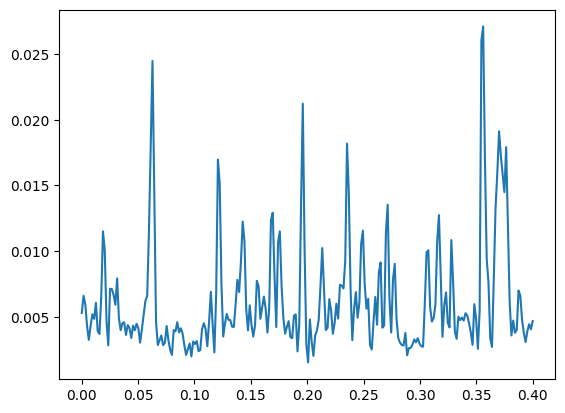

In [25]:
plt.plot(omega/(2*jnp.pi), jnp.abs(Hzz_diag))


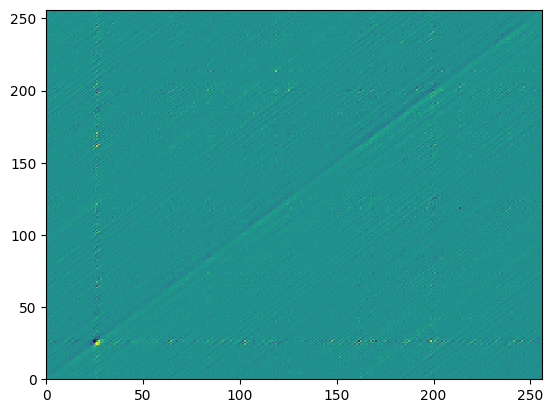

In [ ]:
plt.pcolormesh(jnp.imag(Hzz)[0])